We were testing an adaptive linear control variate that goes through the initial condition.


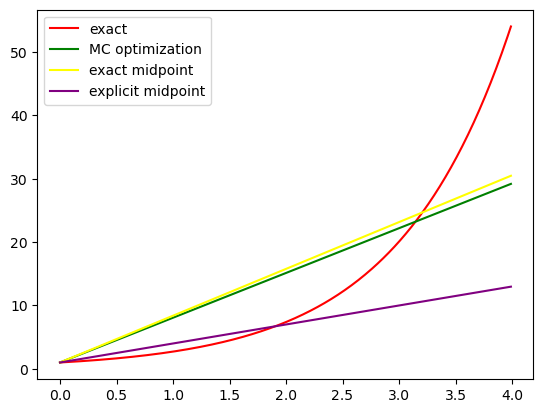

In [2]:
from random import random
import numpy as np
import matplotlib.pyplot as plt

def control(x,a): return a*x+1

def Y(t,a): 
    S = random()*t
    return 1+t +a*t**2/2 + ((Y(S,a)-control(S,a) if random()<t else 0) if t<1 else t*(Y(S,a)-control(S,a)) )

def A(t,a):
    S = random()*t  
    return a+ 3*(Y(S,a)- a*S-1)*S/t**2

t = 4
a_mid = 1+t/2
a,nsim = a_mid,10**3
for _ in range(2):
    a = sum(A(t,a) for _ in range(nsim))/nsim 

xs = np.arange(0,t,0.01)
ys = np.exp(xs)
zs = a*xs+1
qs  = np.exp(t/2)*xs+1
a_mid = 1+t/2
qs2 = a_mid*xs+1
plt.plot(xs,ys,color="red", label="exact")
plt.plot(xs,zs,color="green", label="MC optimization")
plt.plot(xs,qs,color="yellow", label="exact midpoint")
plt.plot(xs,qs2,color="purple", label="explicit midpoint")

plt.legend()
plt.show()

Ok lets try to implement a second order Monte Carlo type ODE solver based on the midpoint method.

6.914360538579073e-07


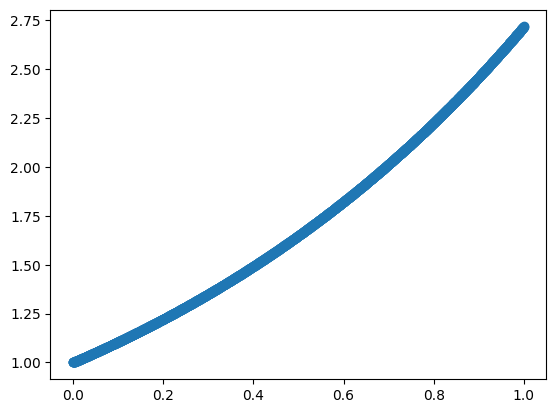

In [160]:
from random import random
from math import exp
import matplotlib.pyplot as plt

def Y_fast(t, T, yT, DT, a_mid):
    S = T + random()*(t-T)  # \sim Uniform(T,t)
    return yT + (yT-T*a_mid)*(t-T)+ a_mid*(t**2-T**2)/2 + (DT*(Y_fast(S, T, yT, DT, a_mid)- (yT + a_mid*(S-T))) if random() < (t-T)/DT else 0)

slow_points = []
def Y_slow(T, DT: "step size slow recursion"):
    TT = T-DT if T-DT > 0 else 0  # TT is where we are recursing to
    YTT = Y_slow(TT, DT) if T > 0 else 1
    a_mid = YTT + T*YTT/2
    sol = Y_fast(T, TT, YTT, T-TT, a_mid) if T > 0 else 1
    slow_points.append((T, sol))
    return sol


T, DT, nsim = 1, 0.0005, 1
sol = sum(Y_slow(T, DT) for _ in range(nsim))/nsim

x, y = zip(*slow_points)
plt.scatter(x, y)
plt.show()


The following is adding a first order control variate: 

In [7]:
from random import random
from math import exp,pow
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange

@njit(fastmath=True)
def Y_fast(t, T, yT, DT):
    S = T + random()*(t-T)  # \sim Uniform(T,t)
    sol = yT*(1 + (1-T)*(t-T)+ (t**2-T**2)/2)
    sol += (DT*(Y_fast(S, T, yT, DT) -yT*(1+S-T)) if random() < (t-T)/DT else 0)
    return sol 


@njit(fastmath=True)
def Y_slow(T, DT: "step size slow recursion"):
    y,t = 1,0
    while t<T:
        tt = t+DT if t+DT<T else T
        y = Y_fast(tt, t, y, tt-t) 
        t=tt
    return y


@njit(fastmath=True, parallel=True)
def sol(T, DT, nsim ):
    total = 0.0
    for _ in prange(nsim):
        total += Y_slow(T,DT)
    return total/nsim

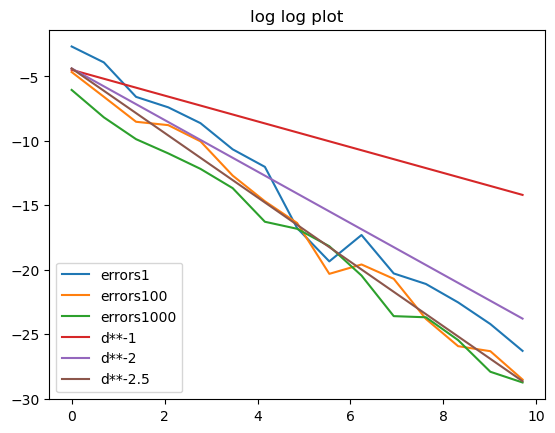

[6.86844215e-02 1.99643306e-02 1.37750885e-03 6.11289772e-04
 1.79337191e-04 2.35390237e-05 6.03711717e-06 5.24605159e-08
 3.94702904e-09 3.05362191e-08 1.54961424e-09 6.84387302e-10
 1.63858359e-10 3.05937820e-11 3.81244296e-12]
[9.45975315e-03 1.38647753e-03 1.99624190e-04 1.53696288e-04
 4.38260352e-05 3.06994495e-06 4.18501650e-07 7.76766775e-08
 1.50078223e-09 3.10700230e-09 1.02215073e-09 4.54097453e-11
 5.49178340e-12 3.71892590e-12 4.12172240e-13]
[2.36023718e-03 2.81416466e-04 5.17546968e-05 1.71645982e-05
 5.16849856e-06 1.15870625e-06 8.53766035e-08 4.95096779e-08
 1.28131555e-08 1.31666721e-09 5.64607453e-11 5.16655318e-11
 8.78327143e-12 7.54627390e-13 3.28631934e-13]


In [8]:
T = 2
#DTS = np.array([0.1,0.01,0.001,0.0001])
DTS = np.power(0.5,np.array(range(15)))
errors1 = np.array([(abs(sol(T, d, 1 )-exp(T)))/(exp(T)) for d in DTS])
errors100 = np.array([(abs(sol(T, d, 10**2 )-exp(T)))/(exp(T)) for d in DTS])
errors1000 = np.array([(abs(sol(T, d, 10**3 )-exp(T)))/(exp(T)) for d in DTS])
ref = np.array([d/89 for d in DTS])
ref2 = np.array([pow(d,2)/80 for d in DTS])
ref3 = np.array([pow(d,2.5)/80 for d in DTS])

plt.plot(-np.log(DTS),np.log(errors1), label = "errors1")
plt.plot(-np.log(DTS),np.log(errors100), label = "errors100")
plt.plot(-np.log(DTS),np.log(errors1000), label = "errors1000")
plt.plot(-np.log(DTS),np.log(ref),label ='d**-1')
plt.plot(-np.log(DTS),np.log(ref2), label="d**-2")
plt.plot(-np.log(DTS),np.log(ref3), label="d**-2.5")
plt.legend()
plt.title("log log plot")
plt.show()

print(errors1)
print(errors100)
print(errors1000)

That $2.5$ speed of convergence is weird. We will look at another ode example:
$$
y' = ty + (1 - t) e^{t}, y(0)=1.
$$ 
this has solution $e^{t}$. <br>
The integral equation for this is:
$$
y(t)= y(T) + \int_{T}^{t} s y(s)ds + \int_{T}^{t}(1-s) e^{s}ds .
$$ 
again the second integral is way easier to deal with as the first. What we want are unbiased estimates of these terms with a variance complexity of $O(DT^{4})$. We search for control variates of the first term using Taylor expansions:
$$
\begin{align*}
sy(s) &= Ty(T) + (s-T)D_{x}|_{T}(x y(x)) + O((s-T)^{2}) \\
 &= Ty(T) + (s-T)(y(T) + T y'(T)) + O((s-T)^{2})
\end{align*}
$$ 
using this on the first integral gets you:
$$
\begin{align*}
\int_{T}^{t} s y(s)ds =& \int_{T}^{t} s y(s) - Ty(T) - (s-T)(y(T) + T y'(T))  ds 
\\ &+ \int_{T}^{t} Ty(T) + (s-T)(y(T) + T y'(T)) ds
\end{align*}
$$ 
We didn't do a variance analysis for RMC but we hope that the control variating gets the variance down. Now we will deal with the non recursive integrals again control variating and using regular MC gets the job done (you can be more generous with more accurate control variate because it's cheaper). In this case it is possible to evaluate these analytically:
$$
\int_{T}^{t} (1-s)e^{s}ds = (2-s)e^{s}|_{T}^{t}.
$$ 

$$
\begin{align*}
\int_{T}^{t} &Ty(T) + (s-T)(y(T) + T y'(T)) ds= \\
 & (t-T)Ty(T) \\
 & +\frac{t^{2}-T^{2}}{2}(y(T)+Ty'(T)) \\
 & -(t-T)T(y(T)+Ty'(T))
\end{align*}

$$
Lets try to implement this:

In [2]:
from random import random
from math import exp,pow
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange

@njit(fastmath=True)
def Y_fast(t, T, yT,dyT, DT):
    sol = yT # initial condiiton
    sol += (2-t)*exp(t) -(2-T)*exp(T) # source  
    sol += (t-T)*T*yT # 0 order control
    sol += (t**2-T**2)*(yT+T*dyT)/2 # 1 order control
    sol += -(t-T)*T*(yT+T*dyT) # 1 order control
    # sol += (t-T)**(3) *(random()-0.5) # unbiased error for testing
    # sol += (t-T)**(4) *(random()) # biased error for testing
    l = 1 # >1 russian roulette parameter 
    if random()*l < (t-T)/DT:
        S = T + random()*(t-T)  # \sim Uniform(T,t)
        sol += l*DT*(S*Y_fast(S, T, yT, dyT, DT) -yT*T-(S-T)*(yT+T*dyT)) 
    return sol 


@njit(fastmath=True)
def Y_slow(T, DT: "step size slow recursion"):
    y,t = 1,0
    while t<T:
        tt = t+DT if t+DT<T else T
        dy = t*y + (1-t)*exp(t) 
        y = Y_fast(tt, t, y,dy, tt-t) 
        t=tt
    return y


@njit(fastmath=True, parallel=True)
def sol(T, DT, nsim ):
    total = 0.0
    for _ in prange(nsim):
        total += Y_slow(T,DT)
    return total/nsim

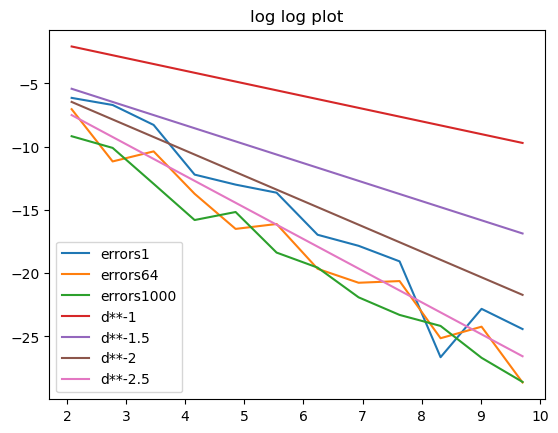

[2.14971306e-03 1.22614888e-03 2.53463169e-04 4.99674018e-06
 2.26564607e-06 1.19750264e-06 4.30825157e-08 1.79778719e-08
 5.26102416e-09 2.69985438e-12 1.23241904e-10 2.49725412e-11]
[8.79182779e-04 1.41633588e-05 3.13191737e-05 1.09823062e-06
 6.84338662e-08 1.00864076e-07 2.92676379e-09 9.70229772e-10
 1.10829281e-09 1.21055311e-11 3.01312452e-11 3.66375324e-13]
[1.03893542e-04 4.12622325e-05 2.41549042e-06 1.37997995e-07
 2.60110037e-07 1.05313712e-08 3.21748406e-09 3.06904003e-10
 7.63595652e-11 3.19538662e-11 2.57496463e-12 3.82241972e-13]


In [5]:
T =2
#DTS = np.array([0.1,0.01,0.001])
DTS = np.power(0.5,np.array(range(3,15)))
errors1 = np.array([(abs(sol(T, d, 1 )-exp(T)))/(exp(T)) for d in DTS])
errors64 = np.array([(abs(sol(T, d, 64 )-exp(T)))/(exp(T)) for d in DTS])
errors1000 = np.array([(abs(sol(T, d, 10**3 )-exp(T)))/(exp(T)) for d in DTS])
ref = np.array([d for d in DTS])
ref1 = np.array([pow(d,1.5)/10 for d in DTS])
ref2 = np.array([pow(d,2)/10 for d in DTS])
ref3 = np.array([pow(d,2.5)/10 for d in DTS])

plt.plot(-np.log(DTS),np.log(errors1), label = "errors1")
plt.plot(-np.log(DTS),np.log(errors64), label = "errors64")
plt.plot(-np.log(DTS),np.log(errors1000), label = "errors1000")
plt.plot(-np.log(DTS),np.log(ref),label ='d**-1')
plt.plot(-np.log(DTS),np.log(ref1), label="d**-1.5")
plt.plot(-np.log(DTS),np.log(ref2), label="d**-2")
plt.plot(-np.log(DTS),np.log(ref3), label="d**-2.5")
plt.legend()
plt.title("log log plot")
plt.show()

print(errors1)
print(errors64)
print(errors1000)

we did 2 extra tests with this code, adding unbiased errors of different orders and biased errors of different orders (see comments). <br>    

Last example works well for small $t$. A high $t$ results in a big coefficient in front of $y$ which causes the variance to explode it doesn't hurt the order. Hopefully implicit methods fix this problem.

Now lets try the second stiff problem from wikipedia (https://en.m.wikipedia.org/wiki/Stiff_equation):
$$
y' = -15y, y(0)=1.
$$ 
this has solution $y(t)=e^{-15t}$. The integral equation for this is:
$$
y(t) = y(T) - \int_{T}^{t} 15 y(s) ds.
$$ 



This is the explicit implementation:

In [325]:
from random import random
from math import exp,pow
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange

@njit(fastmath=True)
def Y_fast(t, T, yT, DT):
    sol = yT*(1 -15*((1-T)*(t-T)+ (t**2-T**2)/2))
    if random() < (t-T)/DT: 
        S = T + random()*(t-T)  # \sim Uniform(T,t)
        sol -= 15*DT*(Y_fast(S, T, yT, DT) -yT*(1+S-T))
    return sol 


@njit(fastmath=True)
def Y_slow(T, DT: "step size slow recursion"):
    y,t = 1,0
    while t<T:
        tt = t+DT if t+DT<T else T
        y = Y_fast(tt, t, y, tt-t) 
        t=tt
    return y


@njit(fastmath=True, parallel=True)
def sol(T, DT, nsim ):
    total = 0.0
    for _ in prange(nsim):
        total += Y_slow(T,DT)
    return total/nsim

In [338]:
T = 0.5
print(sol(T,0.1,10)-exp(-15*T))
print(sol(T,0.2,10)-exp(-15*T))

0.03607048531725052
-43.946595194656176


which suffers from stiffness problems. In the next implementation we try a control variate based on based on backward Euler.

In [945]:
from random import random
from math import exp,pow
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange

@njit(fastmath=True)
def Y_fast(t, T, yT,yy, DT):
    sol = yT 
    sol -= 15*(t-T)*yT
    sol -= 15*((t**2-T**2)/2 - T*(t-T))*(yy-yT)/DT
    if random() < (t-T)/DT: 
        S = T + random()*(t-T)  # \sim Uniform(T,t)
        sol -= 15*DT*(Y_fast(S, T, yT,yy, DT) -yT- (S-T)*(yy-yT)/DT)
    return sol 


@njit(fastmath=True)
def Y_slow(T, DT: "step size slow recursion"):
    y,t = 1,0
    while t<T:
        tt = t+DT if t+DT<T else T
        yy = y/(1 + 15*(tt-t))
        y = Y_fast(tt, t, y,yy ,tt-t) 
        t=tt
    return y


@njit(fastmath=True, parallel=True)
def sol(T, DT, nsim ):
    total = 0.0
    for _ in prange(nsim):
        total += Y_slow(T,DT)
    return total/nsim

def beuler(T, DT: "step size slow recursion"):
    y,t = 1,0
    while t<T:
        tt = t+DT if t+DT<T else T
        y = y/(1 + 15*(tt-t))
        t=tt
    return y

In [960]:
T = 0.5
print(sol(T,0.1,10)-exp(-15*T))
print(sol(T,0.2,10)-exp(-15*T))
print(beuler(T,0.2)-exp(-15*T))

-0.00013052870679403197
0.4126768417626135
0.02444691562985217


Ok here is a second try: <br>
In $1$ inner iteration we can get unbiased $y(T)$, an approximate $\tilde{y}(T+DT)$ from backwards Euler and what we want is an unbiased $y(T+DT)$ that is close to $\tilde{y}(T+DT)$. <br> 
In this prototype we will try to correct backwards Euler using an exponential integrators (if that isn't what we are doing green function stuff then). We can easily obtain the green functions of first order linear odes with constant coefficients (take $q$ constant):
$$
y' +qy= (-15+q)y.
$$ 
this comes with following integral equations (by integrating factor or green function stuff):
$$
y(t)= y(T) e^{q(T-t)} + \int_{T}^{t} e^{q(s-t)} (-15 +q) y(s)ds.
$$ 
what we want is that the recursive integral is small, this can be achieved by $q = 15$ but we want to chose $q$ on basis of our $\tilde{y}(T+DT)$. This can be done by choosing $q$ such that
$$
\begin{align*}
y(T) e^{-qDT} &= \tilde{y}(T+DT) \iff\\
q &= -\frac{\ln{\left(\frac{\tilde{y}(T+DT)}{y(T)} \right)} }{DT}
\end{align*}
$$ 
this generalizes to more dimensions where you would chose $q$ to be a diagonal matrix. If you use $y$ instead of $\tilde{y}$ you also get $q =15$. When $\frac{\tilde{y}(T+DT)}{y(T)} <0$ things break and you can take $q = 0$ (or maybe complex number stuff). Lets implement this with no control variates:

In [1]:
from random import random
from math import exp,pow,log
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange

@njit(fastmath=True)
def Y_fast(t, T, yT,q, DT):
    sol = yT*exp(q*(T-t))
    if random() < (t-T)/DT: 
        S = T + random()*(t-T)  # \sim Uniform(T,t)
        sol += DT*exp(q*(S-t))*(q-100)*Y_fast(S, T, yT, q, DT) 
    return sol 


@njit(fastmath=True)
def Y_slow(T, DT: "step size slow recursion"):
    y,t = 1,0
    while t<T:
        tt = t+DT if t+DT<T else T
        yy = y/(1 + 100*(tt-t))
        q = -(log(yy/y))/(tt-t)
        y = Y_fast(tt, t, y,q ,tt-t) 
        t=tt
    return y


@njit(fastmath=True, parallel=True)
def sol(T, DT, nsim ):
    total = 0.0
    for _ in prange(nsim):
        total += Y_slow(T,DT)
    return total/nsim

def beuler(T, DT: "step size slow recursion"):
    y,t = 1,0
    while t<T:
        tt = t+DT if t+DT<T else T
        y = y/(1 + 100*(tt-t))
        t=tt
    return y

In [941]:
T = 0.5
l = -100
print((sol(T,0.0005,1)-exp(l*T))/exp(l*T))
print((sol(T,0.005,1)-exp(l*T))/exp(l*T))
print((sol(T,0.05,1)-exp(l*T))/exp(l*T))
print((sol(T,0.1,10**2)-exp(l*T))/exp(l*T))
print((beuler(T,0.0005)-exp(l*T))/exp(l*T))
print((beuler(T,0.005)-exp(l*T))/exp(l*T))
print((beuler(T,0.05)-exp(l*T))/exp(l*T))
print((beuler(T,0.1)-exp(l*T))/exp(l*T))

4.6858186818664614e-05
-0.0766803507268828
4.796437381413244e+20
6.570612962234422e+26
2.3529341580668093
12751.583903902107
85745550183080.64
3.2192942164824016e+16


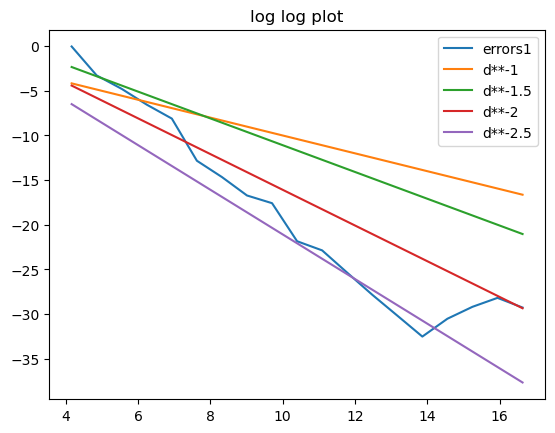

[9.75066198e-01 3.79336132e-02 8.40942073e-03 1.43514965e-03
 3.01695603e-04 2.67489866e-06 4.30441764e-07 5.46329247e-08
 2.30576626e-08 3.23930615e-10 1.16339912e-10 9.56814386e-12
 8.07167772e-13 7.78888865e-14 7.43540231e-15 5.48513285e-14
 2.08556940e-13 5.68259764e-13 1.92345325e-13]


In [7]:
T =0.5
def exact(t): return exp(-100*t)
#DTS = np.array([0.1,0.01,0.001])
DTS = np.power(0.5,np.array(range(6,25)))
errors1 = np.array([(abs(sol(T, d, 1 )-exact(T)))/(exact(T)) for d in DTS])
#errors64 = np.array([(abs(sol(T, d, 64 )-exact(T)))/(exact(T)) for d in DTS])
#errors1000 = np.array([(abs(sol(T, d, 10**3 )-exact(T)))/(exact(T)) for d in DTS])
ref = np.array([d for d in DTS])
ref1 = np.array([pow(d,1.5)*50 for d in DTS])
ref2 = np.array([pow(d,2)*50 for d in DTS])
ref3 = np.array([pow(d,2.5)*50 for d in DTS])

plt.plot(-np.log(DTS),np.log(errors1), label = "errors1")
#plt.plot(-np.log(DTS),np.log(errors64), label = "errors64")
#plt.plot(-np.log(DTS),np.log(errors1000), label = "errors1000")
plt.plot(-np.log(DTS),np.log(ref),label ='d**-1')
plt.plot(-np.log(DTS),np.log(ref1), label="d**-1.5")
plt.plot(-np.log(DTS),np.log(ref2), label="d**-2")
plt.plot(-np.log(DTS),np.log(ref3), label="d**-2.5")
plt.legend()
plt.title("log log plot")
plt.show()

print(errors1)
#print(errors64)
#print(errors1000)

We are not sure what to make of this convergence plot.

Now lets try the second stiff problem from wikipedia (https://en.m.wikipedia.org/wiki/Stiff_equation):
$$
x'= Ax, x= (1 \text{ } 0)^{T}.
$$ 
with 
$$
A = \begin{pmatrix}
0 & 1 \\
-1000 & -1001
\end{pmatrix}.
$$ 



Ok lets try to make an implicit RRMC method control variated via backward Euler:
$$
x(t)=x(T)+\int_{T}^{t}Ax(s)ds .
$$ 
we will make a control variate by connecting x(T) with a straight line to an approximate (biased) $\tilde{x}(T +DT)$ obtained by backward Euler (implicit): 
$$
\tilde{x}(T+DT)=(I-DTA)^{-1}x(T).
$$ 

$$
x(s) \approx x(T) + (s-T)\frac{\tilde{x}(T+DT)-x(T)}{DT}.
$$ 
using this as a control variate for the recursive integral:
$$
\begin{align*}
&\int_{T}^{t} Ax(s)ds \\ 
&= \int_{T}^{t} A \left(x(s)-x(T)-(s-T)\frac{\tilde{x}(T +DT) - x(T)}{DT}\right) ds \\
&+ \int_{T}^{t}  A \left((s-T)\frac{\tilde{x}(T +DT) - x(T)}{DT}\right) ds
\end{align*}
$$ 

again the last integral can be evaluated analytically:
$$
\begin{align*}
\int_{T}^{t}  &A \left((s-T)\frac{\tilde{x}(T +DT) - x(T)}{DT}\right) ds
\\=& \frac{t^{2}-T^{2}}{2} \left(\frac{\tilde{x}(T +DT) - x(T)}{DT}\right) \\
& -(t-T)TA \left(\frac{\tilde{x}(T+DT)-x(T)}{DT} \right)

\end{align*}

$$ 
here is the implementation of this:

In [385]:
from random import random
from math import exp,pow
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange

A = np.array([[0,1],[-1000,-1001]])
I = np.identity(2)

def Y_fast(t, T, yT,yy, DT):
    sol = yT # initial condition
    sol += (t-T)*T*yT # 0 order control
    sol += ((t**2-T**2)/2 - (t-T)*T)*np.matmul(A,(yy-yT)/DT) # 1 order control
    if random() < (t-T)/DT:
        S = T + random()*(t-T)  # \sim Uniform(T,t)
        sol += DT*(np.matmul(A,Y_fast(S, T, yT, yy, DT) -yT-(S-T)*(yy-yT)/DT)) 
    return sol 


def Y_slow(T, DT: "step size slow recursion"):
    y,t = np.array([1.0,0.0]),0.0
    while t<T:
        tt = t+DT if t+DT<T else T
        yy = np.linalg.solve(I-(tt-t)*A,y) 
        y = Y_fast(tt, t, y,yy, tt-t) 
        t=tt
    return y


def sol(T, DT, nsim ):
    total = 0.0
    for _ in range(nsim):
        total += Y_slow(T,DT)
    return total/nsim

In [386]:
print(sol(1,0.01,10))
print(sol(1,0.01,10))
print(sol(1,0.001,10))
print(sol(1,0.001,10))

[-1.22817277e+182  1.22817277e+185]
[ 1.02806769e+199 -1.02806769e+202]
[ 2.36061969 -2.36061969]
[ 2.36055295 -2.36055295]


Lets try exponential RRMC guided by backward Euler:
$$
x(t)= e^{D(T-t)}x(T) + \int_{T}^{t} e^{D(s-t)}(A+D)x(s)ds .
$$ 
with $D$ a diagonal matrix we still can chose. Copy and paste out thought path of the previous example and chose $D$ as follows:
$$
D_{j}= -\frac{\ln{\left( \frac{\tilde{x}_{j}(t + DT)}{x_{j }(t)} \right)}}{DT}.
$$ 



In [173]:
from random import random
from math import exp,pow,log
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange

A = np.array([[0,1],[-1000,-1001]])
I = np.identity(2)

@njit(fastmath =True)
def Y_fast(t, T, yT,D, DT):
    DDTt = np.diag(np.exp(np.diag(D*(T-t))))
    sol = DDTt @ yT
    if random() < (t-T)/DT:
        S = T + random()*(t-T)  # \sim Uniform(T,t)
        DDst = np.diag(np.exp(np.diag(D*(S-t))))
        sol += DT*DDst @ ((A+D) @ Y_fast(S, T, yT, D, DT)) 
    return sol 


@njit(fastmath =True)
def Y_slow(T, DT: "step size slow recursion"):
    y,t = np.array([1.0,-0.001]),0.0
    D = np.array([[0.0,0.0],[0.0,1000.0]])
    while t<T:
        tt = t+DT if t+DT<T else T
        """
        yy = np.linalg.solve(I-(tt-t)*A,y) 
        for i in range(len(D)):
            if yy[i]*y[i]<0:
                pass
                #print(yy[i],y[i])
            else:
                D[i,i]= -log(yy[i]/y[i])/DT 
        """
        y = Y_fast(tt, t, y,D, tt-t) 
        t=tt
    return y


@njit(fastmath=True, parallel=True)
def sol(T, DT, nsim ):
    total = np.zeros(2)
    for _ in prange(nsim):
        total += Y_slow(T,DT)
    return total/nsim


In [198]:
def exact(t):
    x = -exp(-1000*t)/999 + 1000*exp(-t)/999
    dx = 1000*exp(-1000*t)/999 - 1000*exp(-t)/999
    return np.array([x,dx])

def test(t):
    print((sol(t,0.1,10**3)-exact(t))/exact(t))
    print((sol(t,0.05,10**3)-exact(t))/exact(t))
    print((sol(t,0.01,10**3)-exact(t))/exact(t))
    print((sol(t,0.001,10)-exact(t))/exact(t))

test(1)

[0.17722997 0.91068881]
[0.56251199 0.41556415]
[-0.00392759  0.05649763]
[-0.01020025  0.07065514]


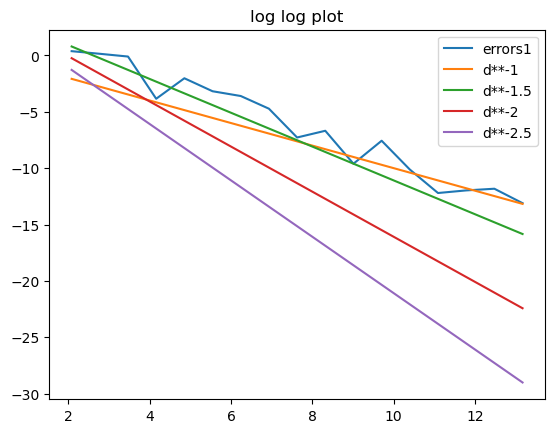

[1.45714351e+00 1.15460365e+00 9.05005674e-01 2.14040307e-02
 1.31705406e-01 4.16730550e-02 2.73016380e-02 8.86659494e-03
 6.88581082e-04 1.24980051e-03 6.72334787e-05 5.16374457e-04
 4.01845463e-05 5.00196332e-06 6.30034039e-06 7.31337752e-06
 2.03262503e-06]


In [355]:
T =0.9
def exact(t):
    x = -exp(-1000*t)/999 + 1000*exp(-t)/999
    dx = 1000*exp(-1000*t)/999 - 1000*exp(-t)/999
    return np.array([x,dx])

#DTS = np.array([0.1,0.01,0.001])
DTS = np.power(0.5,np.array(range(3,20)))
errors1 = np.array([(abs(sol(T, d, 1 )[0]-exact(T)[0]))/(exact(T)[0]) for d in DTS])
ref = np.array([d for d in DTS])
ref1 = np.array([pow(d,1.5)*50 for d in DTS])
ref2 = np.array([pow(d,2)*50 for d in DTS])
ref3 = np.array([pow(d,2.5)*50 for d in DTS])

plt.plot(-np.log(DTS),np.log(errors1), label = "errors1")
plt.plot(-np.log(DTS),np.log(ref),label ='d**-1')
plt.plot(-np.log(DTS),np.log(ref1), label="d**-1.5")
plt.plot(-np.log(DTS),np.log(ref2), label="d**-2")
plt.plot(-np.log(DTS),np.log(ref3), label="d**-2.5")
plt.legend()
plt.title("log log plot")
plt.show()

print(errors1)

Doesn't work how we want it to. We tested around with some $D$ and removing the diagonal seems to stabilize results.

In [26]:
import numpy as np

def test(d1,d2):
    A = np.array([[0,1],[-1000, -1001]])
    D = np.identity(2)
    D[0,0]=d1
    D[1,1]=d1
    print(np.linalg.eig(A+D)[0]) 

test(0,0)
test(1,0)
test(0,1)
test(1000,0)
test(1000,0)
test(500,1000)
test(500,1000)

[   -1. -1000.]
[   0. -999.]
[   -1. -1000.]
[9.99000000e+02 2.08166817e-17]
[9.99000000e+02 2.08166817e-17]
[ 499. -500.]
[ 499. -500.]


Lets now do a linear boundary problem:
$$
y''= y, y(-1)=e^{-1},y(1)=e^{1}.
$$ 
with somekind of RRMC, coupled recursion and recursion on the boundary. To turn this into an integral equation we will use green functions. We will use the green function of $y''$ on $[0,1]$ because we can because we can abuse symmetries (this is a special case of walk on spheres).

## boundary green function

$$
\begin{align*}
G''_{b0}(t) &= 0, G(0)=1,G(1)=0 \Rightarrow \\
G_{b0}(t) &= 1-t
\end{align*}
$$ 

$$
\begin{align*}
G''_{b1}(t) &= 0, G(0)=0,G(1)=1 \Rightarrow \\
G_{b1}(t) &= t
\end{align*}
$$ 

## source green function
$$
\begin{align*}
G''_{s}(t) &= \delta(t-s), G(0)=0,G(1)=0 \Rightarrow \\
G_{s}(t) &= (s-1)t \text{ if } t<s \text{ else } s(t-1)
\end{align*}
$$ 

We will do 2-phase coupled recursion with $y(-0.5),y(0.5)$ and $y(0)$ by integrating over $[-0.5,0.5]$ and $[-1,0],[0,1]$ but lets first test if the translation symmetry works by solving on these domains with exact boundaries.

In [143]:
from random import random
from math import exp

def Gb0(t): return 1-t
def Gb1(t): return t
def G(t,s): return (s-1)*t if t<s else s*(t-1)

def Y(t,b0,b1): 
    U = random()
    if random()<0.5:
        return Gb0(t)*b0 + Gb1(t)*b1 + 2*G(t,U) * Y(U,b0,b1) 
    return Gb0(t)*b0 + Gb1(t)*b1



1.8591409142295225
1.6487212707001282
